Example Profiling
==============================



Example using cProfile/pstats
-----------------------------

Following an example how to profile the algorithm using https://docs.python.org/3/library/profile.html


In [1]:

import IPTestSuite
import IPLazyPRM_Roundtrip
import IPVisibilityPRM_Roundtrip
import IPBasicPRM_Roundtrip
import IPVISVisibilityPRM
import HelperClass
from IPPerfMonitor import IPPerfMonitor



from __future__ import print_function
import sys

from IPython.utils import io

from matplotlib import pylab as plt

benchList = IPTestSuite.benchList
print(benchList)


start = benchList[0].startList
goal = benchList[0].goalList

plannerFactory = dict()

# basicConfig = dict()
# basicConfig["radius"] = 3
# basicConfig["numNodes"] = 200
# plannerFactory["basePRM"] = [IPBasicPRM_Roundtrip.BasicPRM, basicConfig, IPVISBasicPRM.basicPRMVisualize]

visbilityConfig = dict()
visbilityConfig["ntry"] = 300
plannerFactory["visibilityPRM"] = [IPVisibilityPRM_Roundtrip.VisPRM, visbilityConfig, IPVISVisibilityPRM.visibilityPRMVisualize ]

# lazyConfig = dict()
# lazyConfig["initialRoadmapSize"] = 50
# lazyConfig["updateRoadmapSize"]  = 2
# lazyConfig["kNearest"] = 10
# plannerFactory["lazyPRM"] = [IPLazyPRM_Roundtrip.LazyPRM, lazyConfig, IPVISLazyPRM.lazyPRMVisualize]

[<IPBenchmark.Benchmark object at 0x7f3b624f3710>, <IPBenchmark.Benchmark object at 0x7f3b6213ebd0>, <IPBenchmark.Benchmark object at 0x7f3b6213efd0>, <IPBenchmark.Benchmark object at 0x7f3b6213f750>, <IPBenchmark.Benchmark object at 0x7f3b62154390>]


In [2]:
class ResultCollection (object):
    
    def __init__(self, plannerFactoryName, planner, benchmark, solution, perfDataFrame):
        self.plannerFactoryName = plannerFactoryName
        self.planner = planner
        self.benchmark = benchmark
        self.solution = solution
        self.perfDataFrame = perfDataFrame

In [3]:
resultList = list()
testList = benchList[:1]

for key,producer in list(plannerFactory.items()):
    HelperClass.HelperClass.printInColor(str(key)+" "+ str(producer), 'yellow')
    #print(key, producer)
    for benchmark in testList:
        #HelperClass.HelperClass.printInColor("Planning: " + key + " - " + benchmark.name, 'yellow')
        #planner = IPBasicPRM.BasicPRM(benchmark.collisionChecker)
        planner = producer[0](benchmark.collisionChecker)
        IPPerfMonitor.clearData()
        

        try:
            with io.capture_output() as captured:
                resultList.append(ResultCollection(key,
                                        planner, 
                                        benchmark, 
                                        planner.planRoundPath(benchmark.startList,benchmark.interimGoalList,benchmark.goalList,producer[1]),
                                        IPPerfMonitor.dataFrame()),)
            #a = planner.planPath(benchmark.startList,benchmark.goalList,producer[1])
            # print("")


        except Exception as e:
            HelperClass.HelperClass.printInColor("PLANNING ERROR ! PLANNING ERROR ! PLANNING ERROR", 'red')
            HelperClass.HelperClass.printInColor(e, 'red')
            pass

        

In [4]:
# Executing the planning. Stats data will be saved in astarstats
import cProfile
from IPPRMBase import PRMBase

print(benchList)

planner = producer[0](benchmark.collisionChecker)

with io.capture_output() as captured:
    cProfile.run('solution =planner.planRoundPath(benchList[0].startList,benchList[0].interimGoalList,benchList[0].goalList,producer[1])','visibilitystats') # will save astartstats to current directory


[<IPBenchmark.Benchmark object at 0x7f3b624f3710>, <IPBenchmark.Benchmark object at 0x7f3b6213ebd0>, <IPBenchmark.Benchmark object at 0x7f3b6213efd0>, <IPBenchmark.Benchmark object at 0x7f3b6213f750>, <IPBenchmark.Benchmark object at 0x7f3b62154390>]


Tue Jan  9 12:12:54 2024    visibilitystats

         659032 function calls (643398 primitive calls) in 1.093 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   118456    0.101    0.000    0.101    0.000 base.py:245(__setattr__)
    75224    0.013    0.000    0.013    0.000 {built-in method builtins.len}
    59228    0.014    0.000    0.014    0.000 base.py:228(_geom)
    31286    0.012    0.000    0.012    0.000 {built-in method builtins.isinstance}
    31270    0.008    0.000    0.008    0.000 {built-in method time.time}
    30139    0.009    0.000    0.009    0.000 {built-in method builtins.hasattr}
    29614    0.025    0.000    0.037    0.000 topology.py:18(_validate)
    29614    0.070    0.000    0.126    0.000 base.py:191(_empty)
    16941    0.004    0.000    0.004    0.000 {method 'append' of 'list' objects}
    15819    0.003    0.000    0.003    0.000 IPEnvironment.py:23(getDim)
    15635    0.054    0.000    0.054

/home/maurice/anaconda3/lib/python3.11/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


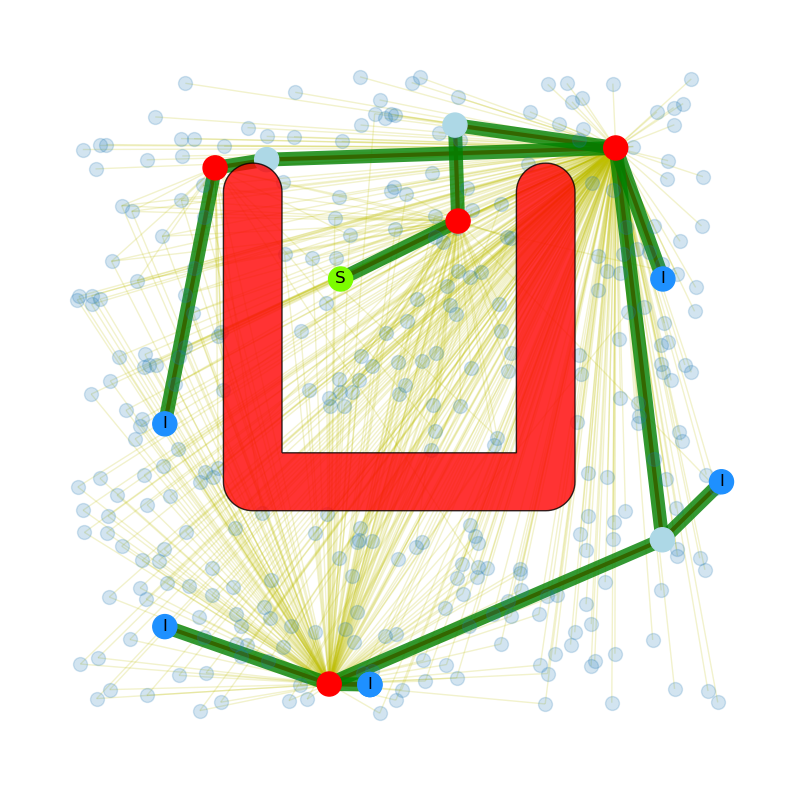

In [5]:
# utility functions to read and access data in astartstats
import pstats
from pstats import SortKey

p = pstats.Stats('visibilitystats')
p.strip_dirs().sort_stats(SortKey.CALLS).print_stats()
p.sort_stats(SortKey.CUMULATIVE).print_stats(15)
p.sort_stats(SortKey.CALLS).print_stats(15)
p.sort_stats(SortKey.TIME).print_stats(15)

fig_local = plt.figure(figsize=(10,10))
ax = fig_local.add_subplot(1,1,1)
  
for bench, result in zip(testList, resultList):
    title = bench.name
    pathLength = dict()
    planningTime = dict()
    roadmapSize  = dict()
    if result.benchmark.name == bench.name:
        #print result.benchmark.name  + " - " +  result.plannerFactoryName, len(result.solution)
        pathLength[result.plannerFactoryName] = len(result.solution)
        planningTime[result.plannerFactoryName] = result.perfDataFrame.groupby(["name"]).sum(numeric_only=True)["time"]["planRoundPath"]
        roadmapSize[result.plannerFactoryName] = result.planner.graph.size()

    IPVISVisibilityPRM.visibilityPRMVisualize(result.planner, result.solution, ax=ax, nodeSize=100)

Example using IPerfMonitor
--------------------------

In [6]:
from IPPerfMonitor import IPPerfMonitor

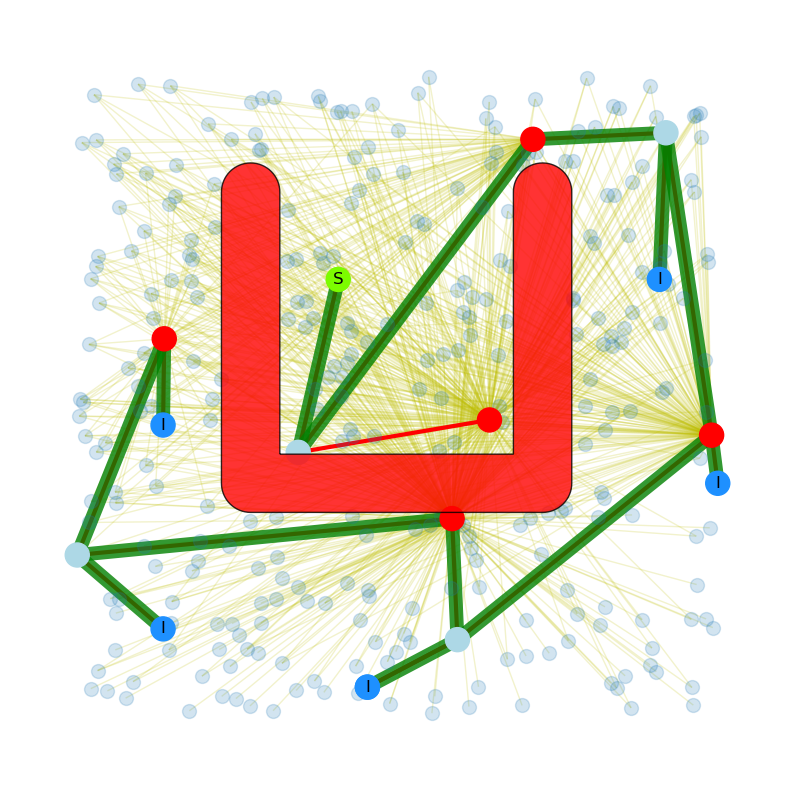

In [7]:
benchList = IPTestSuite.benchList

visbilityConfig = dict()
visbilityConfig["ntry"] = 300
plannerFactory["visibilityPRM"] = [IPVisibilityPRM_Roundtrip.VisPRM, visbilityConfig, IPVISVisibilityPRM.visibilityPRMVisualize ]

with io.capture_output() as captured:
    solution = planner.planRoundPath(benchList[0].startList,benchList[0].interimGoalList,benchList[0].goalList,producer[1])


start = benchList[0].startList
goal = benchList[0].goalList

data_frame = IPPerfMonitor.dataFrame()

fig_local = plt.figure(figsize=(10,10))
ax = fig_local.add_subplot(1,1,1)

IPVISVisibilityPRM.visibilityPRMVisualize(planner, solution, ax=ax, nodeSize=100)

In [8]:
data_frame

name                                               args  \
0      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
1      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
2      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
3      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
4      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
...                 ...                                                ...   
54043     _learnRoadmap  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   
54044     _learnRoadmap  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   
54045     planRoundPath  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   
54046     planRoundPath  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   
54047     planRoundPath  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   

      kwargs                                             retVal      time  
0         {}                                              False  0.000516  
1         {}                                              False  0.000188  
2         {}                                              False  0.000240  
3         {}                                              False  0.000067  
4         {}                                              False  0.000060  
...      ...                                                ...       ...  
54043     {}                                               None  1.042871  
54044     {}                                               None  0.843423  
54045     {}  [start, 13, 17, 0, interim3, 0, 11, interim1, ...  0.793441  
54046     {}  [start, 1, 27, 0, interim2, 0, interim0, 0, 4,...  1.093233  
54047     {}  [start, 14, 10, 26, interim3, 26, 2, interim1,...  0.862558  

[54048 rows x 5 columns]

In [9]:
data_frame.groupby(["name"]).sum(numeric_only=True)

time
name                            
_getRandomFreePosition  0.058113
_learnRoadmap           2.659082
_nearestInterim         0.006935
lineInCollision         2.574162
planRoundPath           2.749232
pointInCollision        2.038633

In [10]:
data_frame.groupby(["name"]).count()

args  kwargs  retVal   time
name                                                
_getRandomFreePosition    940     940     940    940
_learnRoadmap               3       3       0      3
_nearestInterim            67      67      67     67
lineInCollision          1905    1905    1905   1905
planRoundPath               3       3       3      3
pointInCollision        51130   51130   51130  51130

In [11]:
data_frame[data_frame["name"]=="pointInCollision"][data_frame["retVal"]==True].count()

/tmp/ipykernel_10243/2402661994.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_frame[data_frame["name"]=="pointInCollision"][data_frame["retVal"]==True].count()


name      1105
args      1105
kwargs    1105
retVal    1105
time      1105
dtype: int64

Second Example using IPPerfMonitor
----------------------------------

In [12]:
import IPVisibilityPRM_Roundtrip
import IPVISVisibilityPRM

/home/maurice/anaconda3/lib/python3.11/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


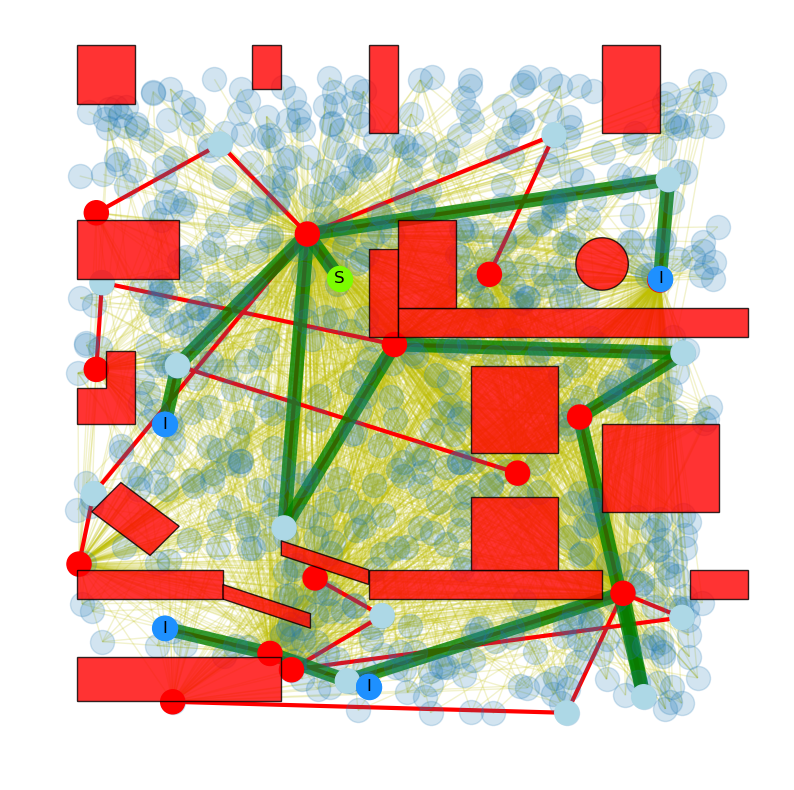

In [13]:
visbilityConfig = dict()
visbilityConfig["ntry"] = 300

vis = plannerFactory["visibilityPRM"][0](benchList[3].collisionChecker)

start = benchList[3].startList
goal = benchList[3].goalList

IPPerfMonitor.clearData()

with io.capture_output() as captured:
    solution = vis.planRoundPath(benchmark.startList,benchmark.interimGoalList,benchmark.goalList,visbilityConfig)

data_frame = IPPerfMonitor.dataFrame()

fig_local = plt.figure(figsize=(10,10))
ax = fig_local.add_subplot(1,1,1)
IPVISVisibilityPRM.visibilityPRMVisualize(vis, solution, ax = ax)

In [14]:
data_frame

name                                               args  \
0      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
1      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
2      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
3      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
4      pointInCollision  (<IPEnvironment.CollisionChecker object at 0x7...   
...                 ...                                                ...   
51888   _nearestInterim  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   
51889   _nearestInterim  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   
51890   _nearestInterim  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   
51891     _learnRoadmap  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   
51892     planRoundPath  (<IPVisibilityPRM_Roundtrip.VisPRM object at 0...   

      kwargs                                             retVal       time  
0         {}                                              False   0.001711  
1         {}                                              False   0.000835  
2         {}                                               True   0.000518  
3         {}                                              False   0.000700  
4         {}                                              False   0.000395  
...      ...                                                ...        ...  
51888     {}              [[3, 3], 6.519299761155275, interim1]   0.000102  
51889     {}             [[3, 3], 3.7135915900015113, interim1]   0.000125  
51890     {}                            [[3, 3], 0.0, interim1]   0.000083  
51891     {}                                               None  14.384006  
51892     {}  [start, 0, 304, interim0, 304, 0, 14, 3, inter...  14.512918  

[51893 rows x 5 columns]

In [15]:
data_frame.groupby(["name"]).count()

args  kwargs  retVal   time
name                                                
_getRandomFreePosition    650     650     650    650
_learnRoadmap               1       1       0      1
_nearestInterim            27      27      27     27
lineInCollision          2419    2419    2419   2419
planRoundPath               1       1       1      1
pointInCollision        48795   48795   48795  48795

In [16]:
data_frame.groupby(["name"]).sum(numeric_only=True)

time
name                             
_getRandomFreePosition   0.226519
_learnRoadmap           14.384006
_nearestInterim          0.002587
lineInCollision         14.201658
planRoundPath           14.512918
pointInCollision        13.930054